# Self-Driving Car Engineer Nanodegree

## Project # 2: Deep Learning - Build a Traffic Sign Recognition Classifier


**Name: Kendrick Amezquita**

**Email: kendrickamezquita@gmail.com**

-----------------

## Importing Packages

In [1]:
import pickle
import csv

import matplotlib.pyplot as plt
# Visualizations will be shown in the notebook.
%matplotlib inline

import matplotlib.mlab as mlab
import random
import numpy as np

import cv2
import random
from sklearn.utils import shuffle

import tensorflow as tf
from tensorflow.contrib.layers import flatten

import os
from os import listdir
from skimage.io import imread

## User Defined Functions

In [2]:
# Load data
dir='./traffic-signs-data'
training_file = dir+'/train.p'
validation_file= dir+'/valid.p'
testing_file = dir+'/test.p'

with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(validation_file, mode='rb') as f:
    valid = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)
    
X_train, y_train = train['features'], train['labels']
X_valid, y_valid = valid['features'], valid['labels']
X_test, y_test = test['features'], test['labels']

with open('signnames.csv', newline='') as csvfile:
    spamreader = csv.reader(csvfile, delimiter=',')
    
    traffic_signs=[]
    for row in spamreader:
        traffic_signs.append(row[1])

traffic_signs.pop(0)

# Data sets summary
def info_dataset(X_train, X_valid, X_test, y_train):
    # TODO: Number of training examples
    n_train = X_train.shape[0]

    # TODO: Number of validation examples
    n_validation = X_valid.shape[0]

    # TODO: Number of testing examples.
    n_test = X_test.shape[0]

    # TODO: What's the shape of an traffic sign image?
    image_shape = X_train[0].shape

    # TODO: How many unique classes/labels there are in the dataset.
    n_classes = max(y_train)+1

    print("Number of training examples =", n_train)
    print("Number of validation examples =", n_validation)
    print("Number of test examples =", n_test)
    print("Image data shape =", image_shape)
    print("Number of classes =", n_classes)
    
# Data sets visualization    
def viz_dataset(X_train, y_train, X_valid, y_valid, X_test, y_test):

    fig, (ax0, ax1, ax2) = plt.subplots(ncols=3, figsize=(15, 5), sharex=True)
    n_classes = int(max(y_train)+1)

    # the histogram of the data
    print("Frequency histogram of traffic signs in datasets\n")

    msg=['Training Dataset','Validation Dataset','Test Dataset']
    num_bins = n_classes
    num_maxfreq = 5

    n0, bins0, patches=ax0.hist(y_train, num_bins, facecolor='g', alpha=0.65)
    ax0.set_title(msg[0])
    ax0.set_ylabel('Frequency')

    n1, bins1, patches=ax1.hist(y_valid, num_bins, facecolor='b', alpha=0.65)
    ax1.set_title(msg[1])
    ax1.set_xlabel('Labels')

    n2, bins2, patches=ax2.hist(y_test, num_bins, facecolor='r', alpha=0.65)
    ax2.set_title(msg[2])

    # Tweak spacing to prevent clipping of ylabel
    fig.tight_layout()
    plt.show()

    sort_n0=np.argsort(n0,axis=-1)
    sort_n1=np.argsort(n1,axis=-1)
    sort_n2=np.argsort(n2,axis=-1)

    maxfreq_labels=[]
    maxfreq_labels=[sort_n0[n_classes-num_maxfreq:]]
    maxfreq_labels=np.append(maxfreq_labels,[sort_n1[n_classes-num_maxfreq:]],axis=0)
    maxfreq_labels=np.append(maxfreq_labels,[sort_n2[n_classes-num_maxfreq:]],axis=0)

    print("Traffic signs with more examples in datasets\n")

    for i,j in enumerate(maxfreq_labels):
        fig, ax = plt.subplots(ncols=num_maxfreq, figsize=(15, 4))
        fig.tight_layout()
        for k in range(num_maxfreq):
            val = j[num_maxfreq-(1+k)]
            ind = np.max(np.where(y_valid==val))
            image = X_valid[ind].squeeze()
            ax[k].imshow(image, cmap="gray")
            ax[k].set_title('Label: '+ str(y_valid[ind]))
            ax[k].axis('off')
        fig.suptitle(msg[i])
        

# Data set pre-processing 
def RGB2GREY(data_RGB):
    
    n_data=data_RGB.shape[0]
    data_gr=np.zeros((n_data,32,32,1))
    for i in range(n_data):
        tmp = cv2.cvtColor(data_RGB[i], cv2.COLOR_RGB2GRAY)
        data_gr[i]= np.reshape(tmp,(32,32,1))
    
    return data_gr

def expand_dataset(data_gr,data_labels):
    
    n_data=data_gr.shape[0]
    
    p_insts=np.zeros(n_classes)
    for i in range(n_classes):
        sum_ints = np.sum(data_labels==i)
        p_insts[i] = sum_ints/n_data
    
    n_aug=int(1.0*n_data)
    aug_X=np.array(np.zeros((n_aug,32,32,1)))
    aug_y=np.array(np.zeros((n_aug)))
    for i in range(n_aug):
        index = random.randint(0, n_data-1)
        aug_X[i]=data_gr[index]
        aug_y[i]=data_labels[index]
        p_trigg = random.uniform(1/np.max(p_insts),1/np.min(p_insts))
        while p_insts[int(aug_y[i])]*p_trigg>1.05:
            index = random.randint(0, n_data-1)
            aug_X[i]=data_gr[index]
            aug_y[i]=data_labels[index]
            sum_ints=np.sum(data_labels==aug_y[i])
            p_trigg = random.uniform(1/np.max(p_insts),1/np.min(p_insts))

    for i in range(n_aug):
        n = random.randint(2,4)
        rot = random.randint(-20, 20)
        M = cv2.getRotationMatrix2D((32/n,32/n),rot,1)
        tmp = cv2.warpAffine(aug_X[i],M,(32,32))
        
        noise = 10*np.random.random((32, 32))
        tmp = tmp+noise
        aug_X[i] = np.reshape(tmp,(32,32,1))
    
    return aug_X, aug_y

def norm_data(data_gr):
    
    return (data_gr-128)/128

### Visualize network's feature maps.
# image_input: the test image being fed into the network to produce the feature maps
# tf_activation: should be a tf variable name used during your training procedure that represents the calculated state of a specific weight layer
# activation_min/max: can be used to view the activation contrast in more detail, by default matplot sets min and max to the actual min and max values of the output
# plt_num: used to plot out multiple different weight feature map sets on the same block, just extend the plt number for each new feature map entry

def outputFeatureMap(image_input, tf_activation, activation_min=-1, activation_max=-1 ,plt_num=1):
    # Here make sure to preprocess your image_input in a way your network expects
    # with size, normalization, ect if needed
    # image_input =
    # Note: x should be the same name as your network's tensorflow data placeholder variable
    # If you get an error tf_activation is not defined it may be having trouble accessing the variable from inside a function
    activation = tf_activation.eval(session=sess,feed_dict={x: image_input})
    featuremaps = activation.shape[3]
    fig = plt.figure(plt_num, figsize=(17,17))
    #fig.tight_layout()
    for featuremap in range(featuremaps):
        plt.subplot(10,8, featuremap+1) # sets the number of feature maps to show on each row and column
        plt.title('FeatureMap ' + str(featuremap)) # displays the feature map number
        plt.axis('off')
        if activation_min != -1 & activation_max != -1:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", vmin =activation_min, vmax=activation_max, cmap="gray")
        elif activation_max != -1:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", vmax=activation_max, cmap="gray")
        elif activation_min !=-1:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", vmin=activation_min, cmap="gray")
        else:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", cmap="gray")

# Load new test images
def new_dataset():
    # return array of images
    dir='./web-test-images/'

    imagesList = listdir(dir)
    #random.shuffle(imagesList)
    dataset = []
    labels = []
    for i in imagesList:
        tmp = os.path.splitext(os.path.basename(i))[0]
        labels.append(int(tmp[0:2]))
        img = imread(dir + i)
        img = cv2.resize(img, (32, 32))
        img = cv2.GaussianBlur(img,(3,3),0)
        dataset.append(img)

    return np.asarray(dataset), np.asarray(labels)

# New Data set visualization    
def viz_newdataset(ind, num_images):
    
    dir='./web-test-images/'
    
    imagesList = listdir(dir)
    #random.shuffle(imagesList)
    dataset = []
    labels = []
    for i in imagesList:
        tmp = os.path.splitext(os.path.basename(i))[0]
        labels.append(int(tmp[0:2]))
        img = imread(dir + i)
        img = cv2.resize(img, (32, 32))
        dataset.append(img)
        
    new_data = np.asarray(dataset)
    new_labels = np.asarray(labels)
    
    chosen_data = new_data[ind]
    chosen_labels = new_labels[ind]

    fig, ax = plt.subplots(ncols=num_images, figsize=(15, 5))
    fig.tight_layout()
    for k in range(num_images):
        img = chosen_data[k].squeeze()
        ax[k].imshow(img, cmap="gray")
        ax[k].set_title('Label: '+ str(chosen_labels[k]))
        ax[k].axis('off')

### Calculate the accuracy for the new images. 
def evaluate_newdata(new_data, new_labels):
    num_examples = len(new_data)
    total_accuracy = 0
    sess = tf.get_default_session()
    batch_x = new_data
    batch_y = new_labels
    accuracy = sess.run(accuracy_operation, feed_dict={x: batch_x, y: batch_y, keep_prob: 1})
    total_accuracy += (accuracy * len(batch_x))
    return total_accuracy / num_examples*100

-------

## Basic Summary of the Data Set

In [3]:
info_dataset(X_train, X_valid, X_test, y_train)

Number of training examples = 34799
Number of validation examples = 4410
Number of test examples = 12630
Image data shape = (32, 32, 3)
Number of classes = 43


## Exploratory visualization of the dataset

Frequency histogram of traffic signs in datasets



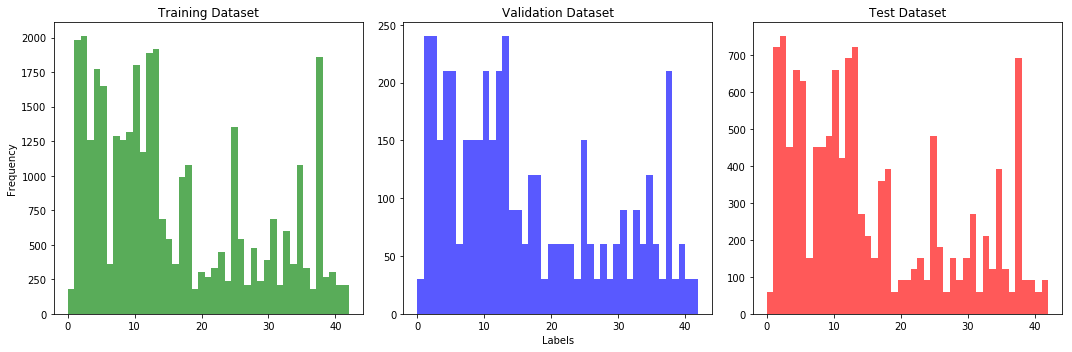

Traffic signs with more examples in datasets



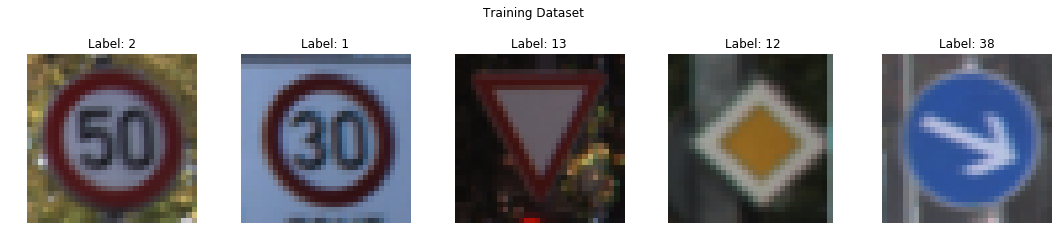

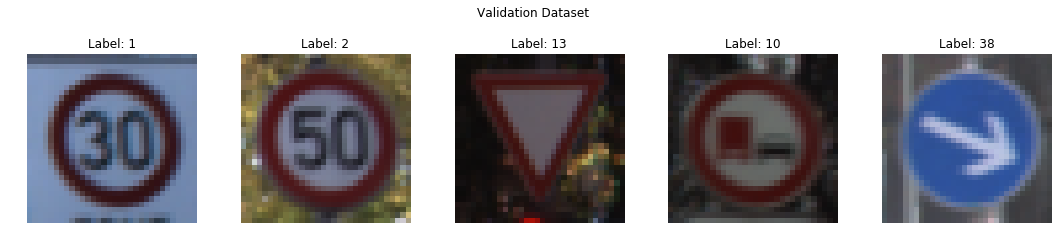

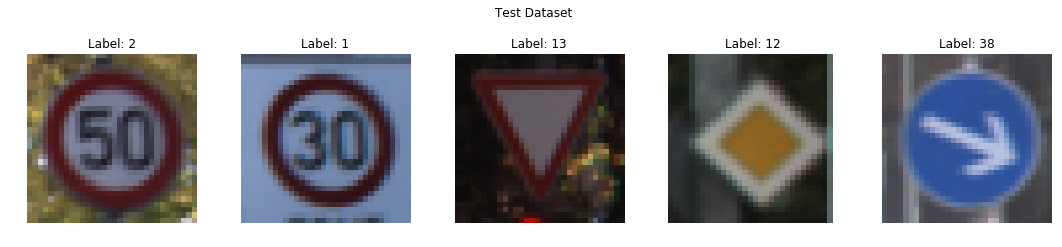

In [4]:
viz_dataset(X_train, y_train, X_valid, y_valid, X_test, y_test)

## Data Set Pre-processing Pipeline

Number of training examples with augmented data= 69598

Frequency histogram of traffic signs in datasets



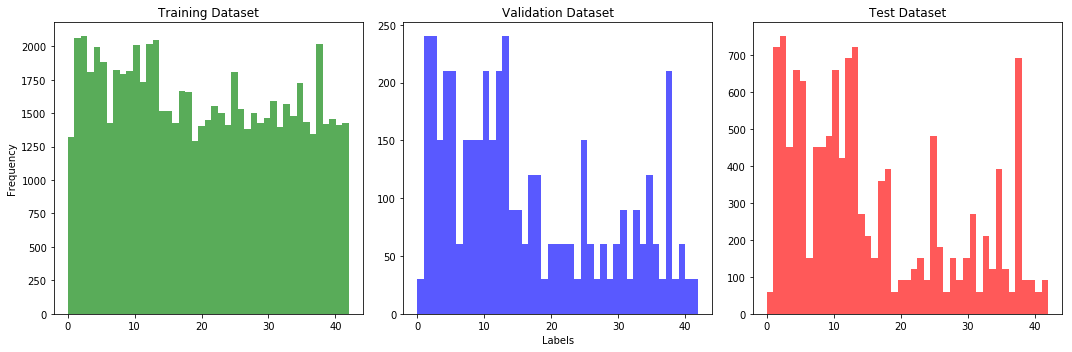

Traffic signs with more examples in datasets



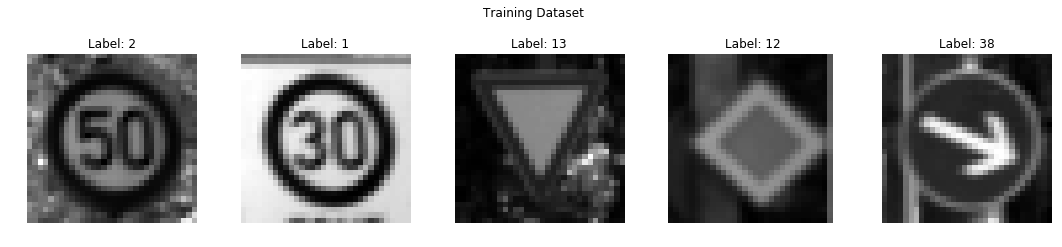

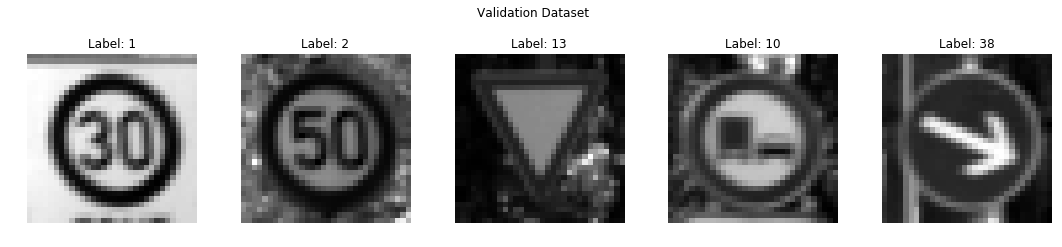

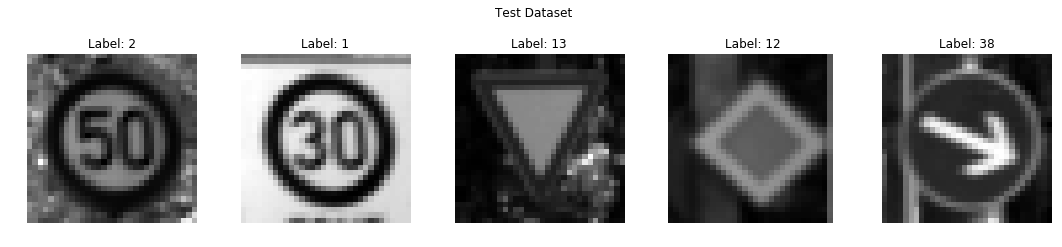

In [5]:
n_classes = int(max(y_train)+1)

# Train data set shuffling
X_train, y_train = shuffle(X_train, y_train)

# Data set RGB images to gray scale
nX_train=RGB2GREY(X_train)
nX_valid=RGB2GREY(X_valid)
nX_test=RGB2GREY(X_test)

# Train data set augmentation with image rotation
aug_X, aug_y=expand_dataset(nX_train, y_train)
nX_train=np.concatenate((nX_train,aug_X))
y_train=np.concatenate((y_train,aug_y))

print("Number of training examples with augmented data=", nX_train.shape[0])
print()

# Data set normalization
nX_train=norm_data(nX_train)
nX_valid=norm_data(nX_valid)
nX_test=norm_data(nX_test)

# New data set visualization
viz_dataset(nX_train, y_train, nX_valid, y_valid, nX_test, y_test)

---------

## Convolutional Neural Network Architecture

In [6]:
EPOCHS = 5
BATCH_SIZE = 128

# Arguments used for tf.truncated_normal
mu = 0
sigma = 0.05

weights = [
        tf.Variable(tf.truncated_normal(shape=(5, 5, 1, 16), mean=mu, stddev=sigma),name="w_conv1"),
        tf.Variable(tf.truncated_normal(shape=(3, 3, 16, 80), mean=mu, stddev=sigma),name="w_conv2"),
        tf.Variable(tf.truncated_normal(shape=(3, 3, 80, 30), mean=mu, stddev=sigma),name="w_conv3"),
        tf.Variable(tf.truncated_normal(shape=(1080,750), mean=mu, stddev=sigma),name="w_fconn1"),
        tf.Variable(tf.truncated_normal(shape=(750, 350), mean=mu, stddev=sigma),name="w_fconn2"),
        tf.Variable(tf.truncated_normal(shape=(350, n_classes), mean=mu, stddev=sigma),name="w_out")]

biases= [
    tf.Variable(tf.zeros([16]),name="b_conv1"),
    tf.Variable(tf.zeros([80]),name="b_conv2"),
    tf.Variable(tf.zeros([30]),name="b_conv3"),
    tf.Variable(tf.zeros([750]),name="b_fconn1"),
    tf.Variable(tf.zeros([350]),name="b_fconn2"),
    tf.Variable(tf.zeros([n_classes]),name="b_out")]

saver = tf.train.Saver()

def MKNet(x, keep_prob):
           
    global conv1, conv2, conv3
        
    stride=[1,1,1,1]
    
    # Layer: Convolutional. Input = 32x32x1. Output = 32x32x24.
    conv1=tf.nn.bias_add(tf.nn.conv2d(x, weights[0], stride, padding='SAME'), biases[0])
    # Activation.
    conv1=tf.nn.relu(conv1)
    # Pooling. Input = 32x32x24. Output = 32x32x24.
    conv1=tf.nn.max_pool(conv1, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME') 

    #Layer: Convolutional. Input = 16x16x24. Output = 14x14x64.
    conv2=tf.nn.bias_add(tf.nn.conv2d(conv1, weights[1], stride, padding='VALID'), biases[1])
    # Activation.
    conv2=tf.nn.relu(conv2)
    # Pooling. Input = 14x14x64. Output = 14x14x64.
    conv2=tf.nn.max_pool(conv2, ksize=[1, 2, 2, 1], strides=[1, 1, 1, 1], padding='SAME')
    
    #Layer: Convolutional. Input = 14x14x64. Output = 12x12x25.
    conv3=tf.nn.bias_add(tf.nn.conv2d(conv2, weights[2], stride, padding='VALID'), biases[2])
    # Activation.
    conv3=tf.nn.relu(conv3)
    # Pooling. Input = 12x12x25. Output = 6x6x25.
    conv3=tf.nn.max_pool(conv3, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')

    # Flatten. Input = 6x6x30. Output = 1080.
    flat = flatten(conv3)
    
    # Layer: Fully Connected. Input = 1260. Output = 750.
    fconn1 = tf.add(tf.matmul(flat, weights[3]), biases[3])
    # Activation.
    fconn1 = tf.nn.dropout(fconn1,keep_prob)

    # Layer: Fully Connected. Input = 750. Output = 350.
    fconn2 = tf.add(tf.matmul(fconn1, weights[4]), biases[4])
    # Activation.
    fconn2 = tf.nn.dropout(fconn2,keep_prob)

    # Layer: Fully Connected. Input = 350. Output = 43.
    logits= tf.add(tf.matmul(fconn2, weights[5]), biases[5])
    
    return logits

### Train and Validate Pipeline

In [7]:
x = tf.placeholder(tf.float32, (None, 32, 32, 1))
y = tf.placeholder(tf.int32, (None))
one_hot_y = tf.one_hot(y, n_classes)

keep_prob = tf.placeholder(tf.float32)

logits = MKNet(x, keep_prob)
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(labels=one_hot_y, logits=logits)
loss_operation = tf.reduce_mean(cross_entropy)
optimizer = tf.train.AdamOptimizer(learning_rate = 0.001)
training_operation = optimizer.minimize(loss_operation)

correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(one_hot_y, 1))
accuracy_operation = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

def evaluate(X_data, y_data):
    num_examples = len(X_data)
    total_accuracy = 0
    sess = tf.get_default_session()
    for offset in range(0, num_examples, BATCH_SIZE):
        batch_x, batch_y = X_data[offset:offset+BATCH_SIZE], y_data[offset:offset+BATCH_SIZE]
        accuracy = sess.run(accuracy_operation, feed_dict={x: batch_x, y: batch_y, keep_prob: 1})
        total_accuracy += (accuracy * len(batch_x))
    return total_accuracy / num_examples

def eval_performance(X_data, y_data, BATCH_SIZE=1):
    num_examples=len(X_data)
    tp = np.zeros(n_classes)
    fp = np.zeros(n_classes)
    fn = np.zeros(n_classes)

    for offset in range(0, num_examples, BATCH_SIZE):
        batch_x, batch_y = X_data[offset:offset+BATCH_SIZE], y_data[offset:offset+BATCH_SIZE]
        pred = sess.run(tf.argmax(logits, 1), feed_dict = {x: batch_x, keep_prob: 1})
        real = batch_y
        out = sess.run(tf.equal(pred, real))
        for i in range(len(out)):  
            if out[i]:
                tp[pred[i]]+=1
            else:
                fp[pred[i]]+=1
                fn[real[i]]+=1
    
    precision = [tp[i]/(tp[i]+fp[i]) if tp[i]!=0 else 0 for i in range(len(tp))]
    recall = [tp[i]/(tp[i]+fn[i]) if tp[i]!=0 else 0 for i in range(len(tp))]
    return precision, recall

In [8]:
init = tf.global_variables_initializer()
with tf.Session() as sess:
    sess.run(init)
    num_examples = len(nX_train)
    
    print("Training...")
    print()
    for i in range(EPOCHS):
        nX_train, y_train = shuffle(nX_train, y_train)
        for offset in range(0, num_examples, BATCH_SIZE):
            end = offset + BATCH_SIZE
            batch_x, batch_y = nX_train[offset:end], y_train[offset:end]
            sess.run(training_operation, feed_dict={x: batch_x, y: batch_y, keep_prob:0.35})

        training_accuracy = evaluate(nX_train, y_train)
        print("EPOCH {} ...".format(i+1))
        print("Training Accuracy = {:.2f}%".format(training_accuracy*100))
        
        validation_accuracy = evaluate(nX_valid, y_valid)
        print("Validation Accuracy = {:.2f}%".format(validation_accuracy*100))
        print()
        
    saver.save(sess, "./mknet")
    print("Model saved")

Training...

EPOCH 1 ...
Training Accuracy = 96.07%
Validation Accuracy = 94.08%

EPOCH 2 ...
Training Accuracy = 97.98%
Validation Accuracy = 96.24%

EPOCH 3 ...
Training Accuracy = 98.78%
Validation Accuracy = 96.73%

EPOCH 4 ...
Training Accuracy = 99.14%
Validation Accuracy = 97.62%

EPOCH 5 ...
Training Accuracy = 99.21%
Validation Accuracy = 97.57%

Model saved


### Test Pipeline

In [8]:
with tf.Session() as sess:
    saver.restore(sess, "./mknet")
    test_accuracy = evaluate(nX_test, y_test)    
    test_precision, test_recall = eval_performance(nX_test, y_test, BATCH_SIZE)

print("Test Accuracy = {:.2f}%".format(test_accuracy*100))
print()

Test Accuracy = 94.52%



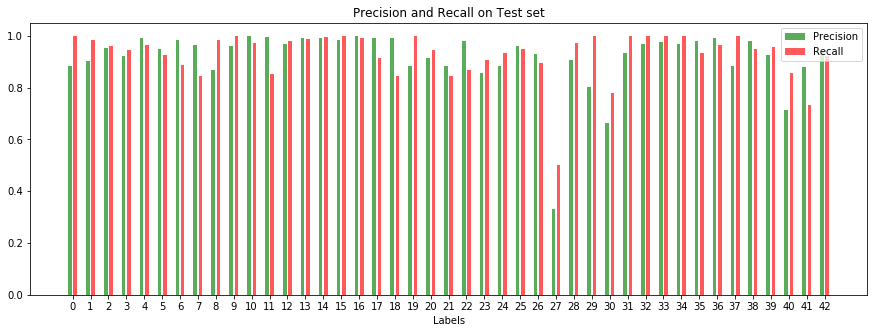

In [9]:
labels = np.asarray([1.*i for i in range(n_classes)])

fig = plt.figure(figsize=(15, 5))
ax = plt.subplot(1,1,1)
l1=ax.bar(labels-0.15, test_precision, width=0.2, facecolor='g', alpha=0.65)
l2=ax.bar(labels+0.15, test_recall, width=0.2, facecolor='r', alpha=0.65)
ax.set_title('Precision and Recall on Test set')
ax.set_xlabel('Labels')
ax.set_xticks(range(n_classes))
plt.legend([l1, l2],["Precision", "Recall"]);

---

## MKNet Test on New Images

### Load and Output new Images

In [10]:
### Load the images and plot them here.
new_data, new_labels = new_dataset()
new_data=RGB2GREY(new_data)
new_data=norm_data(new_data)

print("Traffic signs in New Dataset:",new_data.shape[0],"\n")
for i in new_labels:
    print("Label:",i,"->", traffic_signs[i])

Traffic signs in New Dataset: 30 

Label: 0 -> Speed limit (20km/h)
Label: 0 -> Speed limit (20km/h)
Label: 0 -> Speed limit (20km/h)
Label: 1 -> Speed limit (30km/h)
Label: 1 -> Speed limit (30km/h)
Label: 1 -> Speed limit (30km/h)
Label: 3 -> Speed limit (60km/h)
Label: 6 -> End of speed limit (80km/h)
Label: 9 -> No passing
Label: 11 -> Right-of-way at the next intersection
Label: 13 -> Yield
Label: 14 -> Stop
Label: 14 -> Stop
Label: 17 -> No entry
Label: 18 -> General caution
Label: 22 -> Bumpy road
Label: 22 -> Bumpy road
Label: 23 -> Slippery road
Label: 24 -> Road narrows on the right
Label: 25 -> Road work
Label: 25 -> Road work
Label: 25 -> Road work
Label: 25 -> Road work
Label: 27 -> Pedestrians
Label: 28 -> Children crossing
Label: 28 -> Children crossing
Label: 33 -> Turn right ahead
Label: 35 -> Ahead only
Label: 36 -> Go straight or right
Label: 37 -> Go straight or left


Five randomly chosen images in New Dataset:


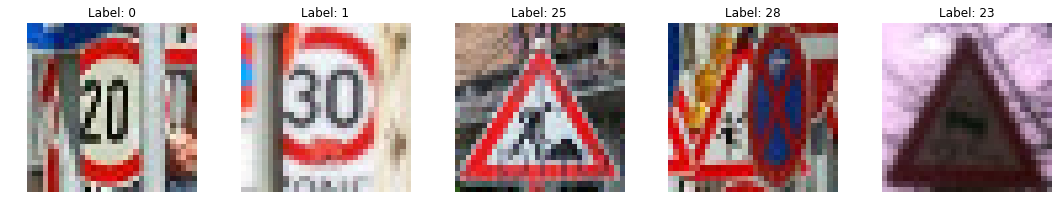

In [25]:
num_examples=5 # max num_images
ind = np.random.randint(0,new_data.shape[0]-1,(5))

chosen_data = new_data[ind]
chosen_labels = new_labels[ind]

print("Five randomly chosen images in New Dataset:")
viz_newdataset(ind,num_examples)

### Predict the Sign Type for Each Image

In [26]:
### Run the predictions here and use the model to output the prediction for each image.
top_softmax=5
with tf.Session() as sess:
    saver.restore(sess, "./mknet")
    softmax = sess.run(tf.nn.softmax(logits), feed_dict={x:chosen_data, keep_prob:1})
    maxsoftmax=sess.run(tf.nn.top_k(softmax, k=top_softmax))
    
pred=maxsoftmax[1]

print("Detected traffic signs:\n")
for i in pred[:,0]:
    print("Label:",i,"->", traffic_signs[i])    

Detected traffic signs:

Label: 0 -> Speed limit (20km/h)
Label: 1 -> Speed limit (30km/h)
Label: 25 -> Road work
Label: 28 -> Children crossing
Label: 23 -> Slippery road


### Analyze Performance

In [61]:
### Calculate the accuracy for the chosen images in new dataset.
with tf.Session() as sess:
    saver.restore(sess, "./mknet")
    accuracy = evaluate_newdata(new_data, new_labels)
    print("Accuracy with new data set = {:.2f}%".format(accuracy))
    accuracy = evaluate_newdata(chosen_data, chosen_labels)
    print("Accuracy with chosen images = {:.2f}%".format(accuracy))
    new_precision, new_recall = eval_performance(new_data, new_labels)

Accuracy with new data set = 86.67%
Accuracy with chosen images = 100.00%


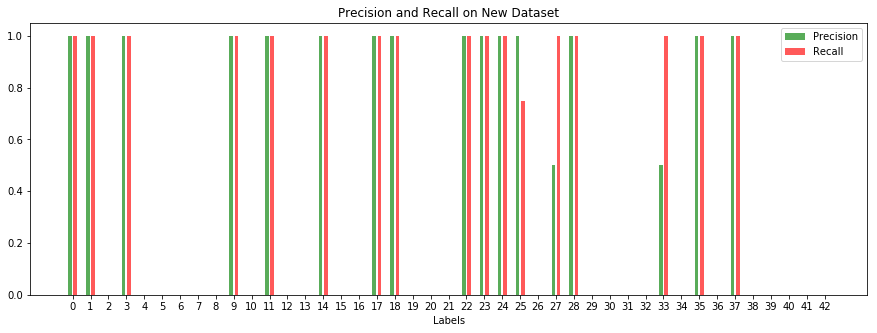

In [62]:
with tf.Session() as sess:
    saver.restore(sess, "./mknet")
    new_precision, new_recall = eval_performance(new_data, new_labels)

labels = np.asarray([1.*i for i in range(n_classes)])

fig = plt.figure(figsize=(15, 5))
ax = plt.subplot(1,1,1)
l1=ax.bar(labels-0.15, new_precision, width=0.2, facecolor='g', alpha=0.65)
l2=ax.bar(labels+0.15, new_recall, width=0.2, facecolor='r', alpha=0.65)
ax.set_title('Precision and Recall on New Dataset')
ax.set_xlabel('Labels')
ax.set_xticks(range(n_classes))
plt.legend([l1, l2],["Precision", "Recall"]);

### Output Top 5 Softmax Probabilities For Each Image Found on the Web

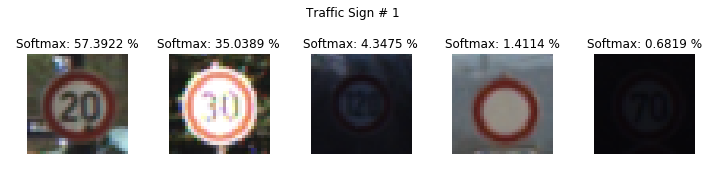

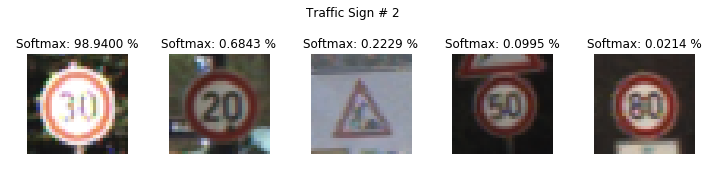

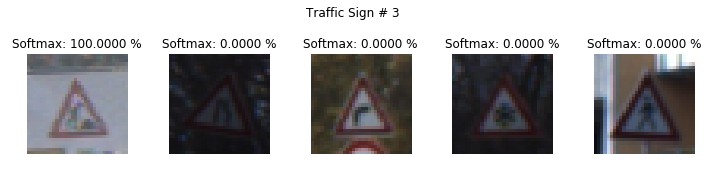

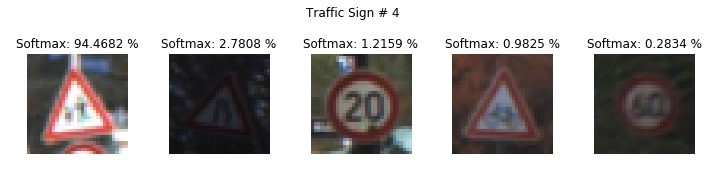

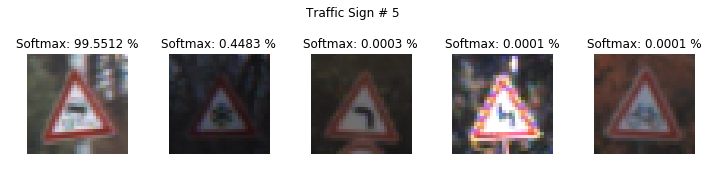

In [43]:
### Print out the top five softmax probabilities for the predictions on the German traffic sign images 
### found on the web. 

for j in range(num_examples):
    fig, ax = plt.subplots(ncols=top_softmax, figsize=(10, 3))
    fig.tight_layout()
    for k in range(top_softmax):
        ind = np.where(y_valid==pred[j,k])
        image = X_valid[ind[0][10]].squeeze()
        ax[k].imshow(image, cmap="gray")
        ax[k].set_title('Softmax: {:.4f} %'.format(maxsoftmax[0][j,k]*100))
        ax[k].set_xlabel('Label: '+ str(pred[j,k]))
        ax[k].axis('off')
    fig.suptitle('Traffic Sign # '+str(j+1))

---

## Visualize the Neural Network's State with Test Image


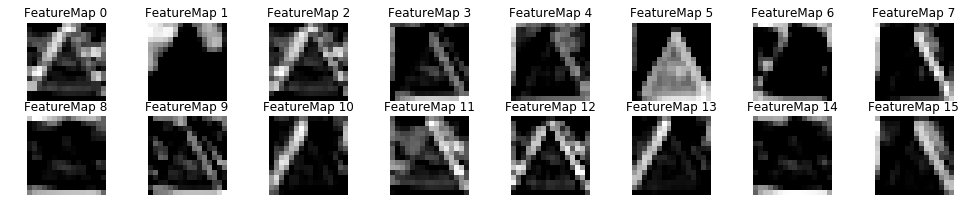

In [63]:
with tf.Session() as sess:
    saver.restore(sess, "./mknet") 
    img = chosen_data[4:5]
    outputFeatureMap(img, conv1)